In [1]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
P99_PERCENTILE_LIST = np.arange(1, 101, 1)
MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)
size_legend_list=['(a) flow size $\in$ (0, 1KB)','(b) flow size $\in$ [1KB,10KB)','(c) flow size $\in$ [10KB,50KB)','(d) flow size $\in$ [50KB,$\infty$)']

In [3]:
mlsys_dir="mlsys"
data_dir='_hpcc'

mix_file = f'../spec/all_counterfactual{data_dir}.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 

save_file=f'./counterfactual{data_dir}.npz'
if not os.path.exists(save_file):
    N_FLOW_THRESHOLD=1
    NR_PATHS_SAMPLED=500
    NR_INTEPOLATE=100
    N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4

    shard_seed=3
    legend_list=['ns3-config','pmn-m',"mlsys"]
    
    
    res_final=[]
    for mix in mixes:
        worst_low_id=mix['id']
        mix_dir = f'../data{data_dir}/{worst_low_id}'
        
        if not os.path.exists(f'{mix_dir}/{legend_list[0]}/elapsed_{shard_seed}.txt'):
            res_final.append(np.zeros((n_size_bucket_list_output+1,2)))
            continue
        df_pmn_m = pd.read_csv(f'{mix_dir}/{legend_list[1]}/records.csv')
        df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
        
        res_tmp=[]
        
        n_freq_list=[]
        n_flow_list=[]
        sizes_pmn=df_pmn_m['size']
        
        path_idx=0
        while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
            with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                lines = file.readlines()
                data=lines[0].strip().split(",")
                n_freq_list.append(int(data[-1]))
                
                flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
                size_list=[sizes_pmn[flowid] for flowid in flowid_list]
                
                n_links=len(data[0].split("|"))-1
                tmp=np.digitize(size_list, bin_size_list)
                # Count occurrences of each bin index
                bin_counts = np.zeros(n_size_bucket_list_output)
                for bin_idx in tmp:
                    bin_counts[bin_idx]+=1
                n_flow_list.append(bin_counts)
            path_idx+=1
        assert sum(n_freq_list)==NR_PATHS_SAMPLED
        n_flow_list=np.array(n_flow_list)
        n_flow_list_sum=n_flow_list.sum(axis=0)
        
        with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
            lines = file.readlines()
            lines = lines[1:]
            for line_idx,line in enumerate(lines):
                data=line.strip().split(",")
                data = [float(value) for value in data]
                assert len(data) == NR_INTEPOLATE
                n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
                
                n_flows_tmp=n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]
                if n_flows_tmp>=N_FLOW_THRESHOLD:
                    for _ in range(n_freq):
                        df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
        
        bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
        
        df_ns3 = pd.read_csv(f'{mix_dir}/{legend_list[0]}/records_{shard_seed}.csv')
        
        sldn_mlsys_p99=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
        
        df_mlsys_total=[]
        for i in range(len(df_mlsys)):
            n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
            df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
        sldn_mlsys_p99=np.percentile(df_mlsys_total,99)

        sizes_ns3=np.array(df_ns3['size'])
        bin_ns3=np.digitize(sizes_ns3, bin_size_list)
        sldn_ns3=df_ns3['slowdown']
        sldn_ns3_p99=np.percentile(sldn_ns3,99)
        

        res_tmp.append([sldn_ns3_p99,sldn_mlsys_p99])
        
        for i in range(len(bin_size_list)+1):
            tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
            tmp_sldn_mlsys=df_mlsys[i]
            
            sldn_ns3_p99=np.percentile(tmp_sldn_ns3,99)
            df_mlsys_p99=np.percentile(tmp_sldn_mlsys,99)
            res_tmp.append([sldn_ns3_p99,df_mlsys_p99])
        res_final.append(res_tmp)
    res = np.array(res_final).transpose()
    np.savez(save_file,res_final=res_final)
else:
    data=np.load(save_file)
    res=data['res_final'].transpose()
   
print(res.shape)

(2, 5, 26)


(2, 26, 2)
(2, 26, 2)
(2, 26, 2)
(2, 26, 2)


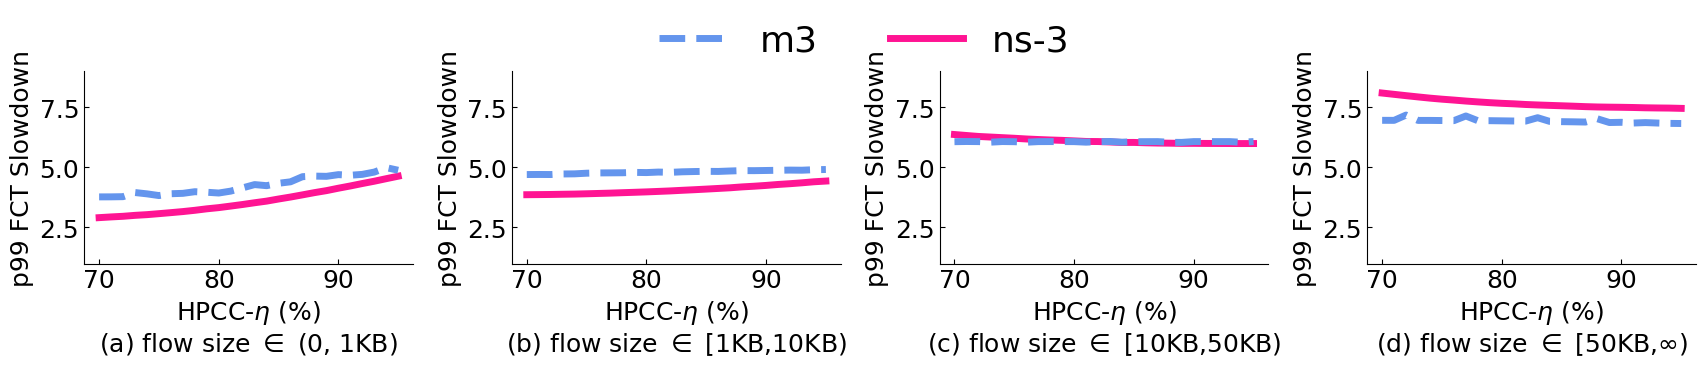

In [4]:

# Define the figure and the subplots
fig, axs = plt.subplots(1, 4, figsize=(5.2*4, 2.5))  # Adjust figsize as needed
loc_list = [1, 1, 1, 1]
_fontsize=18
markertype_list = ["o", "^","x", "x","|"]
color_list = [
    "cornflowerblue",
    "deeppink",
]
line_list = ["--","-", "-.", ":"]
for i in range(1, 5):
    res_tmp=res[:,i]
    plot_res=[]
    for mix_id in range(res_tmp.shape[1]):
        mix=mixes[mix_id]
        key_var=mix["param_1"]
        tmp=[[key_var,res_tmp[1,mix_id]],[key_var,res_tmp[0,mix_id]]]
        plot_res.append(tmp)
    plot_res=np.array(plot_res)
    plot_res=plot_res.transpose(1, 0, 2)
    print(plot_res.shape)

    # Select the subplot to draw on
    ax = axs[i-1]
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    
    # Plotting on the selected subplot
    for line_idx,line in enumerate(plot_res):
        ax.plot(line[:, 0], line[:, 1], color=color_list[line_idx],linewidth=5,linestyle=line_list[line_idx],zorder=10-line_idx)

    ax.set_xlabel(f'HPCC-$\eta$ (%)\n{size_legend_list[i-1]}',fontsize=_fontsize)
    ax.set_ylabel('p99 FCT Slowdown',fontsize=_fontsize)

    ax.set_ylim([1, 9])
    ax.tick_params(axis='both', which='major', labelsize=_fontsize)
# Adjust layout

fig.legend(['m3', 'ns-3'], loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(labels), fontsize=_fontsize+8, frameon=False, markerscale=1.5)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"figs/counterfactual_hpeta.pdf", bbox_inches="tight", pad_inches=0)

In [5]:
mlsys_dir="mlsys"
data_dir='_window'

mix_file = f'../spec/all_counterfactual{data_dir}.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 

save_file=f'./counterfactual{data_dir}.npz'
if not os.path.exists(save_file):
    N_FLOW_THRESHOLD=1
    NR_PATHS_SAMPLED=500
    NR_INTEPOLATE=100
    N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4

    shard_seed=3
    legend_list=['ns3-config','pmn-m',"mlsys"]
    
    res_final=[]
    for mix in mixes:
        worst_low_id=mix['id']
        mix_dir = f'../data{data_dir}/{worst_low_id}'
        
        if not os.path.exists(f'{mix_dir}/{legend_list[0]}/elapsed_{shard_seed}.txt'):
            res_final.append(np.zeros((n_size_bucket_list_output+1,2)))
            continue
        df_pmn_m = pd.read_csv(f'{mix_dir}/{legend_list[1]}/records.csv')
        df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
        
        res_tmp=[]
        
        n_freq_list=[]
        n_flow_list=[]
        sizes_pmn=df_pmn_m['size']
        
        path_idx=0
        while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
            with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                lines = file.readlines()
                data=lines[0].strip().split(",")
                n_freq_list.append(int(data[-1]))
                
                flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
                size_list=[sizes_pmn[flowid] for flowid in flowid_list]
                
                n_links=len(data[0].split("|"))-1
                tmp=np.digitize(size_list, bin_size_list)
                # Count occurrences of each bin index
                bin_counts = np.zeros(n_size_bucket_list_output)
                for bin_idx in tmp:
                    bin_counts[bin_idx]+=1
                n_flow_list.append(bin_counts)
            path_idx+=1
        assert sum(n_freq_list)==NR_PATHS_SAMPLED
        n_flow_list=np.array(n_flow_list)
        n_flow_list_sum=n_flow_list.sum(axis=0)
        
        with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
            lines = file.readlines()
            lines = lines[1:]
            for line_idx,line in enumerate(lines):
                data=line.strip().split(",")
                data = [float(value) for value in data]
                assert len(data) == NR_INTEPOLATE
                n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
                
                n_flows_tmp=n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]
                if n_flows_tmp>=N_FLOW_THRESHOLD:
                    for _ in range(n_freq):
                        df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
        
        bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
        
        df_ns3 = pd.read_csv(f'{mix_dir}/{legend_list[0]}/records_{shard_seed}.csv')
        sldn_mlsys_p99=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
        
        df_mlsys_total=[]
        for i in range(len(df_mlsys)):
            n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
            df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
        sldn_mlsys_p99=np.percentile(df_mlsys_total,99)

        sizes_ns3=np.array(df_ns3['size'])
        bin_ns3=np.digitize(sizes_ns3, bin_size_list)
        sldn_ns3=df_ns3['slowdown']
        sldn_ns3_p99=np.percentile(sldn_ns3,99)

        res_tmp.append([sldn_ns3_p99,sldn_mlsys_p99])
        
        for i in range(len(bin_size_list)+1):
            tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
            tmp_sldn_mlsys=df_mlsys[i]
            
            sldn_ns3_p99=np.percentile(tmp_sldn_ns3,99)
            df_mlsys_p99=np.percentile(tmp_sldn_mlsys,99)
            res_tmp.append([sldn_ns3_p99,df_mlsys_p99])
        res_final.append(res_tmp)
    res = np.array(res_final).transpose()
    np.savez(save_file,res_final=res_final)
else:
    data=np.load(save_file)
    res=data['res_final'].transpose()
   
print(res.shape)

(2, 5, 26)


(2, 26, 2)
(2, 26, 2)
(2, 26, 2)
(2, 26, 2)


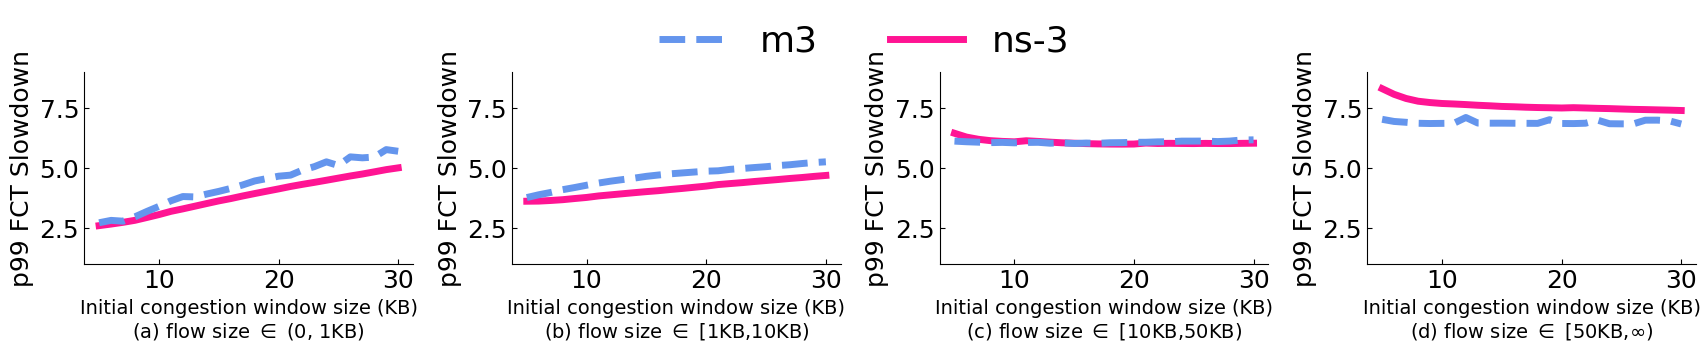

In [6]:

# Define the figure and the subplots
fig, axs = plt.subplots(1, 4, figsize=(5.2*4, 2.5))  # Adjust figsize as needed
loc_list = [1, 1, 1, 1]
_fontsize=18
markertype_list = ["o", "^","x", "x","|"]
color_list = [
    "cornflowerblue",
    "deeppink",
]
for i in range(1, 5):
    res_tmp=res[:,i]
    plot_res=[]
    for mix_id in range(res_tmp.shape[1]):
        mix=mixes[mix_id]
        key_var=mix["window"]/1000
        tmp=[[key_var,res_tmp[1,mix_id]],[key_var,res_tmp[0,mix_id]]]
        plot_res.append(tmp)
    plot_res=np.array(plot_res)
    plot_res=plot_res.transpose(1, 0, 2)
    print(plot_res.shape)

    # Select the subplot to draw on
    ax = axs[i-1]
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    
    # Plotting on the selected subplot
    for line_idx,line in enumerate(plot_res):
        ax.plot(line[:, 0], line[:, 1], color=color_list[line_idx],linewidth=5,linestyle=line_list[line_idx],zorder=10-line_idx)  # Adjust marker size as needed
    ax.set_xlabel(f'Initial congestion window size (KB)\n{size_legend_list[i-1]}',fontsize=_fontsize-4)
    ax.set_ylabel('p99 FCT Slowdown',fontsize=_fontsize)

    ax.set_ylim([1, 9])
    ax.tick_params(axis='both', which='major', labelsize=_fontsize)
# Adjust layout

fig.legend(['m3', 'ns-3'], loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(labels), fontsize=_fontsize+8, frameon=False, markerscale=1.5)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"figs/counterfactual_window.pdf", bbox_inches="tight", pad_inches=0)